In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

import numpy as np
import sklearn
from sklearn import metrics
import nltk 
from collections import Counter
import matplotlib.pyplot as plt
import itertools
import ast

nltk.download('stopwords')
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english'))

### BOOTLEG ###
import import_ipynb
import LoadEntityProfiles

<ipython-input-1-e24ecf0d0430>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)
Matplotlib is building the font cache; this may take a moment.
[nltk_data] Downloading package stopwords to
[nltk_data]     /afs/cs.stanford.edu/u/lorr1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ModuleNotFoundError: No module named 'import_ipynb'

In [2]:
# Bootleg utility functions:
# BY ALIAS: 
def get_candidates(alias):
    try:
        # To get qid candidates of an alias
        cands = LoadEntityProfiles.esp.get_qid_cands(alias)
        print(f"Cands {cands}")
        print([es.get_title(qid) for qid in cands])
    except:
        pass

In [3]:
# Manual User Inputs
model_old = '/dfs/scratch1/simran/bootleg_downstream/error_outputs/posaware_bootlegembed_dev_rev.csv' # OLD BOOTLEG MODEL, deprecated 09062020
model = '/dfs/scratch1/simran/bootleg_downstream/error_outputs/09082020-113324_remapped_ent_dev_rev_ent.csv'
vanilla = '/dfs/scratch1/simran/bootleg_downstream/error_outputs/posaware_baseline_dev_rev.csv'

In [6]:
LABEL_TO_ID = {'no_relation': 0, 'per:title': 1, 'org:top_members/employees': 2, 'per:employee_of': 3, 
               'org:alternate_names': 4, 'org:country_of_headquarters': 5, 'per:countries_of_residence': 6, 
               'org:city_of_headquarters': 7, 'per:cities_of_residence': 8, 'per:age': 9, 
               'per:stateorprovinces_of_residence': 10, 'per:origin': 11, 'org:subsidiaries': 12, 
               'org:parents': 13, 'per:spouse': 14, 'org:stateorprovince_of_headquarters': 15, 'per:children': 16, 
               'per:other_family': 17, 'per:alternate_names': 18, 'org:members': 19, 'per:siblings': 20, 
               'per:schools_attended': 21, 'per:parents': 22, 'per:date_of_death': 23, 'org:member_of': 24, 
               'org:founded_by': 25, 'org:website': 26, 'per:cause_of_death': 27, 
               'org:political/religious_affiliation': 28, 'org:founded': 29, 'per:city_of_death': 30, 
               'org:shareholders': 31, 'org:number_of_employees/members': 32, 'per:date_of_birth': 33, 
               'per:city_of_birth': 34, 'per:charges': 35, 'per:stateorprovince_of_death': 36, 'per:religion': 37, 
               'per:stateorprovince_of_birth': 38, 'per:country_of_birth': 39, 'org:dissolved': 40, 
               'per:country_of_death': 41}

LABEL_LST = list(LABEL_TO_ID.keys())


STANFORD_NER_TYPES = ['DATE', 'LOCATION', 'MONEY', 'ORGANIZATION', 'PERCENT', 'PERSON', 'TIME']
# LABEL_TO_VALID_SUBJ = {
#     'no_relation': [STANFORD_NER_TYPES], 
#     'per:title': [STANFORD_NER_TYPES], 
#     'org:top_members/employees': [PERSON], 
#     'per:employee_of': 3, 
#     'org:alternate_names': 4, 
#     'org:country_of_headquarters': 5, 
#     'per:countries_of_residence': 6, 
#     'org:city_of_headquarters': 7, 
#     'per:cities_of_residence': 8, 'per:age': 9, 
#      'per:stateorprovinces_of_residence': 10, 
#     'per:origin': 11, 
#     'org:subsidiaries': 12
#}
#                'org:parents': 13, 'per:spouse': 14, 'org:stateorprovince_of_headquarters': 15, 'per:children': 16, 
#                'per:other_family': 17, 'per:alternate_names': 18, 'org:members': 19, 'per:siblings': 20, 
#                'per:schools_attended': 21, 'per:parents': 22, 'per:date_of_death': 23, 'org:member_of': 24, 
#                'org:founded_by': 25, 'org:website': 26, 'per:cause_of_death': 27, 
#                'org:political/religious_affiliation': 28, 'org:founded': 29, 'per:city_of_death': 30, 
#                'org:shareholders': 31, 'org:number_of_employees/members': 32, 'per:date_of_birth': 33, 
#                'per:city_of_birth': 34, 'per:charges': 35, 'per:stateorprovince_of_death': 36, 'per:religion': 37, 
#                'per:stateorprovince_of_birth': 38, 'per:country_of_birth': 39, 'org:dissolved': 40, 
#                'per:country_of_death': 41}

In [7]:
# Load the model data 
df_results = pd.read_csv(model)

# Load the baseline data
df_results_vanilla = pd.read_csv(vanilla)

# combine so both have access to the mentions
df_results.rename(columns={'relation':'relation_model'}, inplace=True)
df_results.rename(columns={'prediction':'prediction_model'}, inplace=True)
df_results['relation_vanilla'] = df_results_vanilla['relation']
df_results['prediction_vanilla'] = df_results_vanilla['prediction']

df_errors = df_results[df_results['relation_model'] != df_results['prediction_model']]
df_errors_vanilla = df_results[df_results['relation_vanilla'] != df_results['prediction_vanilla']]

print("FULL_model size: ", df_results.shape)
print("ERRS_model size: ", df_errors.shape)

print("FULL_vanilla size: ", df_results_vanilla.shape)
print("ERRS_vanilla size: ", df_errors_vanilla.shape)



FULL_model size:  (22631, 28)
ERRS_model size:  (2596, 28)
FULL_vanilla size:  (22631, 18)
ERRS_vanilla size:  (2563, 28)


In [8]:
# SCRAP
# df_results_old = pd.read_csv(model_old)
# df_errors_old = df_results_old[df_results_old['relation'] != df_results_old['prediction']]

# df_fixed_by_new = df_errors_old[~df_errors_old['id'].isin(df_errors['id'])]
# df_better_in_old = df_errors[~df_errors['id'].isin(df_errors_old['id'])]
# print(df_better_in_old[df_better_in_old['relation_model'] == 'per:origin'])
# score_corrections(df_better_in_old)

# error_rate_by_relation(df_results,'relation_model', df_errors)
# error_rate_by_relation(df_results_old, 'relation', df_errors_old)

# ctr = Counter(df_errors['obj'].tolist())
# ctr.most_common(100)
# sub_df = df_errors[df_errors['obj'].str.contains('u.s.')]
# for ind, row in sub_df.iterrows():   
#     print(row[['example', 'subj', 'obj', 'subj_mentions', 'obj_mentions', 'relation_model', 'prediction_model']])
#     print()

In [9]:
# Utility functions: accepts a df with corrected slices, and outputs the predicted result
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support as score
def score_corrections(df):
    import scorer
    scorer.score(df['relation_model'].tolist(), df['prediction_model'].tolist(), verbose=True)
    df_errs = df[df['relation_model'] != df['prediction_model']]
    print("Number of Errors: ", df_errs.shape[0])

In [90]:
score_corrections(df_results)

Per-relation statistics:
org:alternate_names                  P:  94.26%  R:  80.17%  F1:  86.65%  #: 348
org:city_of_headquarters             P:  83.33%  R:  50.93%  F1:  63.22%  #: 108
org:country_of_headquarters          P:  61.19%  R:  42.05%  F1:  49.85%  #: 195
org:dissolved                        P:   0.00%  R:   0.00%  F1:   0.00%  #: 1
org:founded                          P:  95.83%  R:  67.65%  F1:  79.31%  #: 34
org:founded_by                       P:  62.86%  R:  58.67%  F1:  60.69%  #: 75
org:member_of                        P: 100.00%  R:   0.00%  F1:   0.00%  #: 7
org:members                          P:  75.00%  R:  70.31%  F1:  72.58%  #: 64
org:number_of_employees/members      P:  66.67%  R:  83.33%  F1:  74.07%  #: 24
org:parents                          P:  47.87%  R:  55.56%  F1:  51.43%  #: 81
org:political/religious_affiliation  P:  30.77%  R:  57.14%  F1:  40.00%  #: 14
org:shareholders                     P:  40.00%  R:  28.57%  F1:  33.33%  #: 35
org:stateorpro

In [21]:
# basic error rate by relation 
def error_rate_by_relation(df_r, key, df_e):
    relation_df = pd.DataFrame(columns=['relation','error_rate','error_count','total_count'])
    index = 0
    for k, v in LABEL_TO_ID.items():
        df_relation_tot = df_r[df_r[key] == k] # all rows with k = true trelation
        tot = df_relation_tot.shape[0] # number of examples with this true relation
    
        df_relation_err = df_e[df_e[key] == k] # error rows with k = true trelation
        err = df_relation_err.shape[0] # number of errors with this true relation
        error_rate = err/tot
    
        relation_df.loc[index] = pd.Series({'relation':k, 'error_rate':error_rate, 'error_count':err, 'total_count':tot})
        index += 1
    
    print(relation_df.sort_values('relation'))

## Analysis by Relation

In [23]:
#error_rate_by_relation(df_results, 'relation_model', df_errors)
relation_df = pd.DataFrame(columns=['relation','error_rate','error_count','total_count'])
index = 0
for k, v in LABEL_TO_ID.items():
        df_relation_tot = df_results[df_results['relation_model'] == k] # all rows with k = true trelation
        tot = df_relation_tot.shape[0] # number of examples with this true relation
    
        df_relation_err = df_errors[df_errors['relation_model'] == k] # error rows with k = true trelation
        err = df_relation_err.shape[0] # number of errors with this true relation
        error_rate = err/tot
    
        relation_df.loc[index] = pd.Series({'relation':k, 'error_rate':error_rate, 'error_count':err, 'total_count':tot})
        index += 1
    
print(relation_df.sort_values('relation'))

                               relation  error_rate error_count total_count
0   no_relation                          0.068432    1186        17331     
4   org:alternate_names                  0.198276    69          348       
7   org:city_of_headquarters             0.490741    53          108       
5   org:country_of_headquarters          0.579487    113         195       
40  org:dissolved                        1.000000    1           1         
29  org:founded                          0.323529    11          34        
25  org:founded_by                       0.413333    31          75        
24  org:member_of                        1.000000    7           7         
19  org:members                          0.296875    19          64        
32  org:number_of_employees/members      0.166667    4           24        
13  org:parents                          0.444444    36          81        
28  org:political/religious_affiliation  0.428571    6           14        
31  org:shar

### What relations are commonly mistaken for each other? 
This shows relations where model starts to do better than the baseline (green), and worse than the baseline (red). Next questions: which of these relations match up to relations contained in Bootleg? Look at examples to see why these get confused for one another. 

- A lot of the inversions are between <no relation, X>, or <X, no relation>

In [24]:
cm_model = sklearn.metrics.confusion_matrix(df_errors['relation_model'], df_errors['prediction_model'], labels=LABEL_LST, sample_weight=None, normalize=None)
cm_vanilla = sklearn.metrics.confusion_matrix(df_errors_vanilla['relation_vanilla'], df_errors_vanilla['prediction_vanilla'], labels=LABEL_LST, sample_weight=None, normalize=None)

thresh = 5
print("These are the relations that most commonly get mistaken for one another (barring confusions with no_relaiton)")
print("TRUE: ", ", PRED: ", ", MODEL numerr: ", ", VANILLA numerr: ")
confusions = {}
for i, j in itertools.product(range(cm_model.shape[0]), range(cm_model.shape[1])):
    if LABEL_LST[i] not in confusions.keys():
        confusions[LABEL_LST[i]] = []
    if cm_model[i, j] > thresh:
        confusions[LABEL_LST[i]].append(LABEL_LST[j])
    
    if cm_model[i, j] > thresh and LABEL_LST[i] != 'no_relation' and LABEL_LST[j] != 'no_relation':
        if cm_model[i, j] > cm_vanilla[i,j] :
            print("\033[91m {}, {}, {}, {}\033[00m".format(LABEL_LST[i], LABEL_LST[j], cm_model[i, j], cm_vanilla[i,j]))
        else:
            print("\033[92m {}, {}, {}, {}\033[00m".format(LABEL_LST[i], LABEL_LST[j], cm_model[i, j], cm_vanilla[i,j]))

relation_df['confused_with:'] = relation_df['relation'].map(confusions)


These are the relations that most commonly get mistaken for one another (barring confusions with no_relaiton)
TRUE:  , PRED:  , MODEL numerr:  , VANILLA numerr: 
 org:top_members/employees, org:founded_by, 9, 3
 org:country_of_headquarters, per:origin, 6, 7
 per:cities_of_residence, per:city_of_death, 6, 3
 per:origin, per:countries_of_residence, 51, 58
 org:subsidiaries, org:parents, 6, 7
 per:children, per:spouse, 9, 7
 per:children, per:parents, 6, 14
 per:parents, per:spouse, 6, 3
 per:city_of_death, per:cities_of_residence, 12, 14
 per:city_of_birth, per:cities_of_residence, 11, 9
 per:stateorprovince_of_death, per:stateorprovinces_of_residence, 10, 21
 per:stateorprovince_of_birth, per:stateorprovinces_of_residence, 6, 5
 per:country_of_death, per:countries_of_residence, 27, 32


In [52]:
cm_model = sklearn.metrics.confusion_matrix(df_errors['relation_model'], df_errors['prediction_model'], labels=LABEL_LST, sample_weight=None, normalize=None)
cm_vanilla = sklearn.metrics.confusion_matrix(df_errors_vanilla['relation_vanilla'], df_errors_vanilla['prediction_vanilla'], labels=LABEL_LST, sample_weight=None, normalize=None)

thresh = 5
print("These are the relations that most commonly get mistaken for one another (barring confusions with no_relaiton)")
print("TRUE: ", ", PRED: ", ", MODEL numerr: ", ", VANILLA numerr: ")
confusions = {}
for i, j in itertools.product(range(cm_model.shape[0]), range(cm_model.shape[1])):
    if LABEL_LST[i] not in confusions.keys():
        confusions[LABEL_LST[i]] = []
    if cm_model[i, j] > thresh:
        confusions[LABEL_LST[i]].append(LABEL_LST[j])
    
    if cm_model[i, j] > thresh and LABEL_LST[i] != 'no_relation' and LABEL_LST[j] == 'no_relation':
        if cm_model[i, j] > cm_vanilla[i,j] :
            print("\033[91m {}, {}, {}, {}\033[00m".format(LABEL_LST[i], LABEL_LST[j], cm_model[i, j], cm_vanilla[i,j]))
        else:
            print("\033[92m {}, {}, {}, {}\033[00m".format(LABEL_LST[i], LABEL_LST[j], cm_model[i, j], cm_vanilla[i,j]))

relation_df['confused_with:'] = relation_df['relation'].map(confusions)

These are the relations that most commonly get mistaken for one another (barring confusions with no_relaiton)
TRUE:  , PRED:  , MODEL numerr:  , VANILLA numerr: 
 per:title, no_relation, 90, 83
 org:top_members/employees, no_relation, 51, 62
 per:employee_of, no_relation, 121, 102
 org:alternate_names, no_relation, 63, 43
 org:country_of_headquarters, no_relation, 102, 108
 per:countries_of_residence, no_relation, 37, 33
 org:city_of_headquarters, no_relation, 42, 47
 per:cities_of_residence, no_relation, 29, 23
 per:age, no_relation, 14, 27
 per:stateorprovinces_of_residence, no_relation, 15, 18
 per:origin, no_relation, 51, 49
 org:subsidiaries, no_relation, 56, 53
 org:parents, no_relation, 31, 30
 per:spouse, no_relation, 38, 41
 org:stateorprovince_of_headquarters, no_relation, 19, 33
 per:children, no_relation, 19, 18
 per:other_family, no_relation, 10, 8
 per:alternate_names, no_relation, 20, 23
 org:members, no_relation, 18, 31
 per:siblings, no_relation, 8, 4
 per:schools_atte

In [25]:
# Sanity Check
# TODO:   ['Mohammed bin Rashid Al Maktoum', 'UNK', 'UNK']    why are two of the three slots 'UNK'?
sub_df = df_errors[df_errors['relation_model'] == 'per:origin']
sub_df = sub_df[sub_df['prediction_model'] == 'per:countries_of_residence']
print(sub_df.shape[0])
#print(sub_df[['example', 'subj', 'obj', 'subj_mentions', 'obj_mentions']])

51


## Keywords By Relation 

Print the most frequent keywords in errors that are not in results for each relation.

In [26]:
#### RESULTS DF ####
keywords_results = {}
punctuation = [',', ':', '.', ';', "'", ')', '(', "'s", '--', '-', '``', "''"]

for k, v in LABEL_TO_ID.items():
    df_relation = df_results[df_results['relation_model'] == k]
    examples = df_relation.loc[:,'example'].tolist()
    examples_toks = [tok for ex in examples for tok in ex.split(" ")]
    examples_toks = [tok for tok in examples_toks if tok not in stop_words and tok not in punctuation]
    keywords_results[k] = Counter(examples_toks).most_common(25)

# add keywords to the relations dataframe
relation_df['keywords:'] = relation_df['relation'].map(keywords_results)


#### ERRORS DF ####
keywords_errors = {}
for k, v in LABEL_TO_ID.items():
    df_relation = df_errors[df_errors['relation_model'] == k]
    examples = df_relation.loc[:,'example'].tolist()
    examples_toks = [tok for ex in examples for tok in ex.split(" ")]
    examples_toks = [tok for tok in examples_toks if tok not in stop_words and tok not in punctuation]
    keywords_errors[k] = Counter(examples_toks).most_common(25)

#### THESE KEYWORDS ARE MOST COMMON FOR THE ERRORS BUT NOT MOST COMMON FOR THE FULL DATA ####
for k, v in LABEL_TO_ID.items():
    tup_lst_results = keywords_results[k]
    lst_results = [tup[0] for tup in tup_lst_results]
    
    tup_lst_errors = keywords_errors[k]
    lst_errors = [tup[0] for tup in tup_lst_errors]
    
    new_keyword_in_errors = [word for word in lst_errors if word not in lst_results]
    print("{}: {}\n".format(k, new_keyword_in_errors))

no_relation: ['chief', 'died', 'minister', 'chairman', 'since', 'death', 'executive', 'american']

per:title: ['last', 'made', 'name', 'university', 'called', 'told', 'famous', 'actress', 'sportswriter', 'los', 'angeles', 'news', 'mayor', 'mohammed']

org:top_members/employees: ['blavatnik', 'access', 'industries', 'len', 'company', 'u.s.', '$', 'hedge', 'million', 'opera', 'industrialist', 'many', 'rajaratnam', 'galleon', 'plans', 'basell']

per:employee_of: ['spent', 'mandelbrot', 'began', '1958', 'research', 'professor', 'institute', 'several', 'la', 'ibm', 'thomas', 'yorktown', 'heights', 'frequently', 'series']

org:alternate_names: ['american', 'science', 'food', 'association', 'advancement', 'aaas', 'sipri', 'society', 'united']

org:country_of_headquarters: ['switzerland', 'million', 'nigeria', 'regulatory', 'percent', 'baer', 'russia']

per:countries_of_residence: ['korea', 'one', 'since', '2003', 'cup', 'zapata', 'cuba', 'jail', 'zimbabwe', 'hwang', 'team', 'received', 'death

### Here we try to extract the examples where the "ner-types" don't typecheck to the relation prediction. E.g. <subj person, obj person> cannot be a country-of-death relation

In [ ]:
relations_subj = {}
relations_obj = {}

for k, v in LABEL_TO_ID.items():
    df_relation = df_results[df_results['relation_model'] == k]
    ner_lst = df_relation.loc[:,'subj_ner'].tolist()
    ner_lst = [ast.literal_eval(value) for value in ner_lst]
    ner_toks = [tag for ner in ner_lst for tag in ner]
    ctr_list = Counter(ner_toks).most_common(2)
    relations_subj[k] = [tup[0] for tup in ctr_list]
    #print(k, ": ", relations[k])
    #print()
    
    ner_lst = df_relation.loc[:,'obj_ner'].tolist()
    ner_lst = [ast.literal_eval(value) for value in ner_lst]
    ner_toks = [tag for ner in ner_lst for tag in ner]
    ctr_list = Counter(ner_toks).most_common(5)
    relations_obj[k] = [tup[0] for tup in ctr_list]
    
count = 0
for ind, row in df_errors.iterrows():
    subj_ner = row['subj_ner']
    subj_ner = ast.literal_eval(subj_ner)
    
    obj_ner = row['obj_ner']
    obj_ner = ast.literal_eval(obj_ner)
    
    relation = row['relation_model']
    prediction = row['prediction_model']
   
    if any(ner for ner in subj_ner if ner not in relations_subj[prediction]) and any(ner for ner in obj_ner if ner not in relations_obj[prediction]):
        print("{}".format(row['example']))
        print("SUBJ MENTION: {}, OBJ: {}".format(row['subj_mentions'], row['obj_mentions']))
        print("PRED {}, GOLD {}: {}/{} for {}/{}\n".format(prediction, relation, row['subj'], subj_ner, row['obj'], obj_ner))
        count += 1
        
print(count)

### Relation groups: 
Some *groups* of relations are more *similar* in nature (e.g., city vs. state of residence shows the model captured at least some granularity of understanding. again for employee vs. top employee). Does our model make more "related errors" than "unrelated errors" vs.  the vanilla/baseline model?

In [28]:
# create the groups (manual!) - note there could be overlap in the groups depending on how they're defined
# if I reclassify relations and preds by their group, then what's the error rate by group?

family_grp = ['per:spouse', 'per:other_family', 'per:parents', 'per:children', 'per:siblings']
death_grp = ['per:date_of_death', 'per:stateorprovince_of_death', 'per:cause_of_death', 'per:city_of_death', 
             'per:country_of_death']
birth_grp = ['per:city_of_birth', 'per:stateorprovince_of_birth', 'per:country_of_birth']
date_grp = ['per:date_of_death', 'per:date_of_birth']
location_grp = ['org:country_of_headquarters', 'per:countries_of_residence', 'org:city_of_headquarters', 
                'per:cities_of_residence', 'per:stateorprovinces_of_residence', 'per:origin', 
                'org:stateorprovince_of_headquarters', ]
employee_grp = ['org:top_members/employees', 'per:employee_of', 'org:member_of', 'org:members', 
                'org:number_of_employees/members']
org_relation = ['org:subsidiaries', 'org:parents', 'org:shareholders', 'org:dissolved', 'org:political/religious_affiliation', 'per:religion']
org_founded = ['org:founded', 'org:founded_by']
religion_grp = ['org:political/religious_affiliation', 'per:religion']
numbers_grp = ['org:number_of_employees/members', 'per:age']


per_grp = ['per:']
org_grp = ['org:']

# OTHER!
# 'per:title': 1, 
# 'per:charges': 35,
# 'org:alternate_names': 4, 
# 'per:alternate_names': 18, 
# 'per:schools_attended': 21, 
# 'org:website': 26

# TODO
# What relations are the best matches given the keywords?

### Uncomment to Inspect some of the relations that get mistaken for each other in raw

Some thoughts about this: 
- Top employee is difficult for humans to differentie from employee (some poorly specified relations in the schema)
    

In [29]:
# sub_df = df_results[df_results['relation_model'] == 'per:title']
# for ind, row in sub_df[sub_df['prediction_model'] == 'per:title'].iterrows():
#     print(row['example']) 
#     print(row['mentions'])
#     print(row['subj'], row['obj']) 
#     print()

In [30]:
# sub_df = df_errors[df_errors['relation_model'] == 'no_relation']
# for ind, row in sub_df[sub_df['prediction_model'] == 'org:top_members/employees'].iterrows():
#     print(row['example']) 
#     print(row['mentions'])
#     print(row['subj'], row['obj']) 
#     print()

# Looking at the Separation between subj and obj

Is it more difficult if the subj and obj are further spread apart in the example? Does it make a difference whether it's subj->obj vs. obj->subj?

max separation:  80
min separation:  0
FULL subj obj separation mean:  12.562060889929743
ERRS subj obj separation mean:  11.243836671802773
FULL num negative separation:  (9879, 28)
ERRS num negative separation:  (1085, 28)

max separation:  80
min separation:  0
FULL_vanilla subj obj separation mean:  12.562060889929743
ERRS_vanilla subj obj separation mean:  11.284432305891533
FULL_vanilla num negative separation:  (9879, 18)
ERRS_vanilla num negative separation:  (1069, 28)


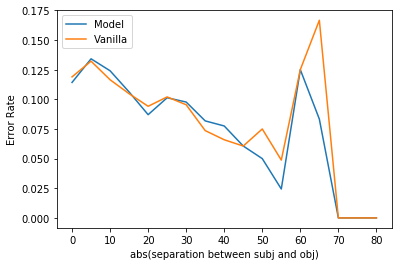

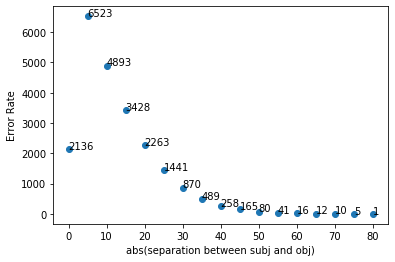

In [31]:
###### SUBJ OBJ SEPARATION ######
def myround(x, base=5):
    return base * round(x/base)

###### MODEL ######
max_sep = df_results['separation_dist'].abs().max()
min_sep = df_results['separation_dist'].abs().min()
print("max separation: ", max_sep)
print("min separation: ", min_sep)

res_buckets = {}
for ind, row in df_results.iterrows():
    val = myround(abs(row['separation_dist']))
    if val in res_buckets:
        res_buckets[val] += 1
    else:
        res_buckets[val] = 1

err_buckets = {}
for ind, row in df_errors.iterrows():
    val = myround(abs(row['separation_dist']))
    if val in err_buckets:
        err_buckets[val] += 1
    else:
        err_buckets[val] = 1

lists_res = sorted(res_buckets.items()) # sorted by key, return a list of tuples
x_res, y_res = zip(*lists_res) # unpack a list of pairs into two tuples
lists_err = sorted(err_buckets.items()) # sorted by key, return a list of tuples
x_err, y_err = zip(*lists_err) # unpack a list of pairs into two tuples
errrate = []
for i in range(len(x_res)):
    if i < len(y_err) and i < len(y_res):
        errrate.append(y_err[i]/y_res[i])
    else:
        errrate.append(0)

plt.plot(x_res, errrate, label="Model")
print("FULL subj obj separation mean: ", df_results['separation_dist'].abs().mean())
print("ERRS subj obj separation mean: ", df_errors['separation_dist'].abs().mean())
print("FULL num negative separation: ", df_results[df_results['separation_dist'] < 0].shape)
print("ERRS num negative separation: ", df_errors[df_errors['separation_dist'] < 0].shape)
print()

###### VANILLA ######
max_sep_v = df_results_vanilla['separation_dist'].abs().max()
min_sep_v = df_results_vanilla['separation_dist'].abs().min()
print("max separation: ", max_sep_v)
print("min separation: ", min_sep_v)

res_buckets_vanilla = {}
for ind, row in df_results_vanilla.iterrows():
    val = myround(abs(row['separation_dist']))
    if val in res_buckets_vanilla:
        res_buckets_vanilla[val] += 1
    else:
        res_buckets_vanilla[val] = 1

err_buckets_vanilla = {}
for ind, row in df_errors_vanilla.iterrows():
    val = myround(abs(row['separation_dist']))
    if val in err_buckets_vanilla:
        err_buckets_vanilla[val] += 1
    else:
        err_buckets_vanilla[val] = 1

lists_res_v = sorted(res_buckets_vanilla.items()) # sorted by key, return a list of tuples
x_res_v, y_res_v = zip(*lists_res_v) # unpack a list of pairs into two tuples
lists_err_v = sorted(err_buckets_vanilla.items()) # sorted by key, return a list of tuples
x_err_v, y_err_v = zip(*lists_err_v) # unpack a list of pairs into two tuples
errrate_v = []
for i in range(len(x_res_v)):
    if i < len(y_err_v) and i < len(y_res_v):
        errrate_v.append(y_err_v[i]/y_res_v[i])
    else:
        errrate_v.append(0)

print("FULL_vanilla subj obj separation mean: ", df_results_vanilla['separation_dist'].abs().mean())
print("ERRS_vanilla subj obj separation mean: ", df_errors_vanilla['separation_dist'].abs().mean())
print("FULL_vanilla num negative separation: ", df_results_vanilla[df_results_vanilla['separation_dist'] < 0].shape)
print("ERRS_vanilla num negative separation: ", df_errors_vanilla[df_errors_vanilla['separation_dist'] < 0].shape)

plt.plot(x_res_v, errrate_v, label="Vanilla")
plt.ylabel('Error Rate')
plt.xlabel('abs(separation between subj and obj)')
plt.legend()
plt.show()

plt.scatter(x_res, y_res)
plt.ylabel('Error Rate')
plt.xlabel('abs(separation between subj and obj)')
for i,j in zip(x_res, y_res):
    plt.annotate(str(j),xy=(i,j))
plt.show()

# Are the exmples with more entities/mentions in the example more difficult?

In [32]:
###### NUM ENTITIES ######
print()
print("FULL model prop ner entities: ", df_results['prop_ner'].mean())
print("ERRS model prop ner entities: ", df_errors['prop_ner'].mean())

print()
print("FULL_vanilla prop ner entities: ", df_results_vanilla['prop_ner'].mean())
print("ERRS_vanilla prop ner entities: ", df_errors_vanilla['prop_ner'].mean())



FULL model prop ner entities:  0.23738384152166184
ERRS model prop ner entities:  0.25336314681081934

FULL_vanilla prop ner entities:  0.23738384152166184
ERRS_vanilla prop ner entities:  0.25166339693469886


In [33]:
###### NUM MENTIONS ######
print()
print("FULL prop boot mentions: ", df_results['prop_mentions'].mean())
print("ERRS model prop boot mentions: ", df_errors['prop_mentions'].mean())
print("ERRS vanilla prop boot mentions: ", df_errors_vanilla['prop_mentions'].mean())


FULL prop boot mentions:  0.26010009298476244
ERRS model prop boot mentions:  0.2746156976402246
ERRS vanilla prop boot mentions:  0.278906476453613


# For the examples our model gets, but the baseline (vanilla) model misses, why does bootleg help?

We want to confirm that the improvement ties back to insights in bootleg - i.e., the mentions/types/relations in bootleg's database.

In [65]:
# get the set difference of errors
df_vanilla_not_model_errors = df_errors_vanilla[~df_errors_vanilla['id'].isin(df_errors['id'])]
df_model_not_vanilla_errors = df_errors[~df_errors['id'].isin(df_errors_vanilla['id'])]
print("The #examples our model improves on vs. baseline are: ", df_vanilla_not_model_errors.shape[0])
print("The #examples our model does worse on vs. baseline are: ", df_model_not_vanilla_errors.shape[0])
# df_vanilla_not_model_errors.to_csv('vanilla_not_model_errors.csv', sep='\t')
# df_model_not_vanilla_errors.to_csv('model_not_vanilla_errors.csv', sep='\t')

The #examples our model improves on vs. baseline are:  743
The #examples our model does worse on vs. baseline are:  776


In [72]:
# some constants
proper_noun = ['NNP', 'NNPS']
nonproper_noun = ['NN', 'NNS']
number_pos = ['CD']
nomention = ["['UNK']", "['UNK', 'UNK']", "['UNK', 'UNK', 'UNK']", "['UNK', 'UNK', 'UNK', 'UNK']", 
             "['UNK', 'UNK', 'UNK', 'UNK', 'UNK']"]
cols = ['example', 'relation_model','prediction_model', 'mentions', 'subj_pos', 'obj_pos', 'subj', 'obj', 'subj_mentions', 'subj_qids', 'obj_mentions', 'obj_qids', 'id']

### look at the proper nouns that the baseline (vanilla) and our model miss

Here we find that the *number* of proper nouns that have errors and receive bootleg mentions are about the same w/ vs. w/out using bootleg entity embeddings. 

In [73]:
lst_pos_subj_vanilla = []
lst_subj_nomention_vanilla = {}
lst_pos_obj_vanilla = []
lst_obj_nomention_vanilla = {}

sub_df = df_vanilla_not_model_errors[cols]
for index, row in sub_df.iterrows():
    if any(pos in row['subj_pos'] for pos in proper_noun): # is the subj a proper noun?
        lst_pos_subj_vanilla.append(row['subj'])
        if any(null in row['subj_mentions'] for null in nomention): # is the bootleg mention empty for this proper noun?
            lst_subj_nomention_vanilla[row['id']] = row['subj']
            
    if any(pos in row['obj_pos'] for pos in proper_noun):
        lst_pos_obj_vanilla.append(row['obj'])
        if any(null in row['obj_mentions'] for null in nomention):
            lst_obj_nomention_vanilla[row['id']] = row['obj']
        
print("The number of proper noun subj in vanilla errors are:", len(lst_pos_subj_vanilla), "and obj are:", len(lst_pos_obj_vanilla))
print("The number of proper noun subj in vanilla errors that don't get a bootleg mention are:", len(lst_subj_nomention_vanilla.keys()), "and obj are:", len(lst_obj_nomention_vanilla.keys()))
print()

lst_pos_subj_vanilla.extend(lst_obj_nomention_vanilla)
print("VANILLA DOES WORSE THAN BOOTLEG MODEL ON THESE SUBJ/OBJ PROPER NOUNS")#print(len(lst_pos_subj_vanilla))
print(set(lst_pos_subj_vanilla))


The number of proper noun subj in vanilla errors are: 582 and obj are: 482
The number of proper noun subj in vanilla errors that don't get a bootleg mention are: 26 and obj are: 44

VANILLA DOES WORSE THAN BOOTLEG MODEL ON THESE SUBJ/OBJ PROPER NOUNS
{"['sidney', 'clifton']", "['taylor']", "['girija', 'prasad', 'koirala']", "['community', 'foundation', 'of', 'middle', 'tennessee']", "['thomas', 'more', 'law', 'center']", "['nigeria', 'police', 'force']", 'e7798b11b9528b5f8555', "['swiss', 'bankers', 'association']", "['washington', 'national', 'opera']", 'e779865fb96c0338dff4', 'e779865fb9c6536475fb', 'e779865fb9eadd1e1cd5', 'e779865fb9703308974b', 'e779865fb9a9ba1735fb', "['frankel']", "['international', 'agency', 'for', 'research', 'on', 'cancer']", "['arcandor']", 'e7798c74c54f76926d4b', "['marc', 'bolland']", "['mohammed', 'sayyed', 'tantawi']", "['benoit', 'mandelbrot']", "['burlington', 'northern', 'santa', 'fe']", "['hwang', 'jang-yop']", "['southgobi', 'energy', 'resources']", 

In [88]:
def get_relations(subj_qids_str, obj_qids_str):
    subj_qids = ast.literal_eval(subj_qids_str)
    obj_qids = ast.literal_eval(obj_qids_str)
    subj_qid = subj_qids[0]
    obj_qid = obj_qids[0]
    
    rels = [LoadEntityProfiles.esp.get_relation_name(r) for r in LoadEntityProfiles.esp.get_all_relations(subj_qid, obj_qid)]
    rels = [LoadEntityProfiles.rel_to_name.get(rel, rel) for rel in rels]
    return rels

In [89]:
lst_pos_subj_model = []
lst_subj_nomention_model = {}
lst_pos_obj_model = []
lst_obj_nomention_model = {}

sub_df = df_model_not_vanilla_errors[cols] #BOOTLEG ERRORs, and NOT BASELINE ERRORS
for index, row in sub_df.iterrows():
    #SUBJ
    if any(pos in row['subj_pos'] for pos in proper_noun):
        lst_pos_subj_model.append(row['subj'])
        print(row[['example', 'subj', 'obj', 'subj_qids', 'obj_qids', 'relation_model', 'prediction_model', 'mentions']])
        rels = get_relations(row['subj_qids'], row['obj_qids'])
        print(f"Rels {rels}")
        print(type(qid_subj))
        print()
        
        if any(null in row['subj_mentions'] for null in nomention):
            lst_subj_nomention_model[row['id']] = row['subj']
            
    #OBJ
    if any(pos in row['obj_pos'] for pos in proper_noun):
        lst_pos_obj_model.append(row['obj'])
        
        if any(null in row['obj_mentions'] for null in nomention):
            lst_obj_nomention_model[row['id']] = row['obj']
        
# print("The number of proper noun subj in model errors are:", len(lst_pos_subj_model), "and obj are:", len(lst_pos_obj_model))
# print("The number of proper noun subj in model errors that don't get a bootleg mention are:", len(lst_subj_nomention_model.keys()), "and obj are:", len(lst_obj_nomention_model.keys()))

# # BOTH SUBJ AND OBJ ARE PROPER - FOR THE PAIR, then what does the mention look like within the mentions in bootleg
# # BOOTLEG looks at POS differently 

# lst_pos_subj_model.extend(lst_pos_obj_model)
# print("BOOTLEG MODEL DOES WORSE THAN VANILLA ON THESE SUBJ/OBJ PROPER NOUNS")
# print(len(set(lst_pos_subj_model)))
# print(set(lst_pos_subj_model))


example             cuba 's human rights record has come into sharp focus since the death of dissident hunger striker orlando zapata tamayo last month drew international condemnation .                                                                                                                                                                                                                                                   
subj                ['orlando', 'zapata', 'tamayo']                                                                                                                                                                                                                                                                                                                                                                                        
obj                 ['last', 'month']                                                                                                           


example             ellie greenwich , a songwriter who collaborated with phil spector , jeff barry and others to create a greatest-hits list of 1960s teenage pop songs like `` da doo ron ron , '' `` then he kissed me , '' `` hanky panky '' and `` leader of the pack , '' died on wednesday in manhattan .                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
subj                ['ellie', 'greenwich']                                                                                                                                                                                              

Name: 5825, dtype: object
Rels []
<class 'str'>

example             the greek government is ready to make any decisions regarding the national economy that serves the interests of greece , prime minister george papandreou said on wednesday evening while addressing the annual general assembly of the association of greek tourism enterprises -lrb- sete -rrb- .                                                                                                                                                                                                                                                                                                                                                                            
subj                ['association', 'of', 'greek', 'tourism', 'enterprises']                                                                                                                                                                                                       

Name: 9999, dtype: object
Rels ['country of citizenship']
<class 'str'>

example             a federal grand jury formally indicted raj rajaratnam and danielle chiesi on tuesday , accusing the billionaire founder of the galleon group and the former bear stearns hedge fund manager of operating at the center of a vast insider trading ring that profited from corporate secrets passed between an extensive network of informants .                                                                                                                                                                                              
subj                ['galleon', 'group']                                                                                                                                                                                                                                                                                                                                                      

Name: 13634, dtype: object
Rels []
<class 'str'>

example             the united nations appointed two foreign members of afghanistan 's election complaints commission -lrb- ecc -rrb- here on saturday .                                                                                                       
subj                ['election', 'complaints', 'commission']                                                                                                                                                                                                   
obj                 ['afghanistan']                                                                                                                                                                                                                            
subj_qids           ['UNK', 'UNK', 'UNK']                                                                                                                                             


example             hsbc confirmed on friday that chief financial officer douglas flint would succeed green as group chairman and stuart gulliver , its head of investment banking , would replace michael geoghegan as chief executive .                                                                                                                                                                                                                      
subj                ['douglas', 'flint']                                                                                                                                                                                                                                                                                                                                                                                                                       
obj                 ['executive']                                                                      


example             sparky anderson , the tigers ' colorful manager , tells all in this , his day-to-day diary of the making of a championship ballclub .                                                                                            
subj                ['sparky', 'anderson']                                                                                                                                                                                                           
obj                 ['tigers']                                                                                                                                                                                                                       
subj_qids           ['Q1133919', 'Q1133919']                                                                                                                                                                                                         
obj_qids       


example             julius baer bought gam from ubs for 5.6 billion swiss francs -lrb- 5.6 billion dollars , 3.6 billion euros -rrb- in 2005 .                                                                                              
subj                ['julius', 'baer']                                                                                                                                                                                                      
obj                 ['gam']                                                                                                                                                                                                                 
subj_qids           ['Q671901', 'Q671901']                                                                                                                                                                                                  
obj_qids            ['Q1250129']                   

In [110]:
# for these proper nouns bootleg does worse on, what's misguiding?
count_errors = 0
relations_errs_matchqids = []
for index, row in df_errors.iterrows():
    # subj qid
    subj_qids_str = row['subj_qids']
    subj_qids = ast.literal_eval(subj_qids_str)
    subj_qid = subj_qids[0]
    
    # obj qid
    obj_qids_str = row['obj_qids']
    obj_qids = ast.literal_eval(obj_qids_str)
    obj_qid = obj_qids[0]
    
    if subj_qid == obj_qid and subj_qid != 'UNK':
        count_errors += 1
        relations_errs_matchqids.append(row['relation_model'])
count_errors
print(Counter(relations_errs_matchqids))

count_results = 0
relations_matchqids = []
for index, row in df_results.iterrows():
    # subj qid
    subj_qids_str = row['subj_qids']
    subj_qids = ast.literal_eval(subj_qids_str)
    subj_qid = subj_qids[0]
    
    # obj qid
    obj_qids_str = row['obj_qids']
    obj_qids = ast.literal_eval(obj_qids_str)
    obj_qid = obj_qids[0]
    
    if subj_qid == obj_qid and subj_qid != 'UNK':
        count_results += 1
        relations_matchqids.append(row['relation_model'])
        
print(Counter(relations_matchqids))
count_results



error_rate_orig = df_errors.shape[0]/df_results.shape[0]
error_rate_new = (df_errors.shape[0]-count)/df_results.shape[0]
print("original number of errors: ", df_errors.shape[0])
print("total instances of two matching qids subj and obj: ", count_results)
print("corrected errors: ", count)
print(error_rate_orig)
print(error_rate_new)

Counter({'org:alternate_names': 42, 'no_relation': 18, 'per:alternate_names': 10, 'org:subsidiaries': 10, 'org:parents': 3, 'per:children': 3, 'org:founded_by': 1})
Counter({'org:alternate_names': 187, 'no_relation': 181, 'org:subsidiaries': 15, 'per:alternate_names': 12, 'per:children': 6, 'per:parents': 4, 'org:parents': 3, 'org:founded_by': 1, 'per:employee_of': 1, 'per:spouse': 1, 'per:cities_of_residence': 1})
original number of errors:  2596
total instances of two matching qids subj and obj:  412
corrected errors:  87
0.11470991118377447
0.11086562679510406


#### For these proper nouns that don't get a bootleg mention, is it because they are not in bootleg's database?

Finding: 59 of those 168 errors are for mentions that are not in Bootleg's databse. There are 33 unique subjects in that list of 59. Something interesting is that for some of these (e.g. ellie gaye, karrera sarobe, ronald james padavona) the tacred entity is their professional \# (e.g. singer name), but the title of the wikipedia page is their real name (e.g. birth name). Generally we should look in the Wikipedia page to add a field for "alternate names" that some entity might go by. Others of these: e.g., "electoral complaints commission", "chinaco" don't have Wikipedia pages at all.  

Further questions: why are the mentions that are actually in bootleg, not being extracted downstream? Do they have too many candidates, making it confusing? Look at the raw sentences.

In [38]:
#print(lst_subj_nomention_model)

no_candidates_values = []
has_candidates_values = []
# alias is the subj/obj that did not receive a bootleg mention
for idx, value in lst_subj_nomention_model.items():
    row = df_results[df_results['id'] == idx]   
    value = ast.literal_eval(value)
    alias = " ".join(value)
    try:
        cands = LoadEntityProfiles.esp.get_qid_cands(alias)
        #print("{}\n{}\n{}\n\n".format(row['example'], alias, f"Cands {cands}") # uncomment to view the alias in context downstream
        has_candidates_values.append(alias)
    except: 
        no_candidates_values.append(alias)

print("Of these values that received no bootleg mention,", len(has_candidates_values), "(total)/", len(set(has_candidates_values)), "(unique), ARE IN the bootleg database.")

######## THIS SET OF ENTITIES SIMPLY DON'T HAVE CANDIDATES FOR THEM IN BOOTLEG! WE SHOULD ADD THEM! ############
print("Of these values that received no bootleg mention,", len(no_candidates_values), "(total)/", len(set(no_candidates_values)), "(unique), ARE NOT IN the bootleg database.")
print()
print(set(no_candidates_values))


Of these values that received no bootleg mention, 7 (total)/ 4 (unique), ARE IN the bootleg database.
Of these values that received no bootleg mention, 27 (total)/ 11 (unique), ARE NOT IN the bootleg database.

{'southgobi energy resources', 'southgobi', 'election complaints commission', 'millipore corp', 'attenti holdings', 'economic cooperation organisation', 'banking regulatory commission', 'karrera sarobe', 'wno', 'millipore corp.', 'millipore'}


In [39]:
# TODO: whether check the type of the subject and object to see if it aligns wiht the relation. 
# e.g. PARIS went to PARIS -- do the types of the entities TYPECHECK (i.e. person, location, organization) -- i.e. a location cannot go to an organzation 
# if "X" in sentence, it cannot be "Y" relation -- we want to do this in a systematic way


# If I fix this bucket, what score would I expect. Modular function. -- 

#### Inspecting the overlap of proper nouns between baseline-only-errs and model-only-errs

In [40]:
### VANILLA ERRORS ###
numobj_err_vanilla_only = len([vanilla for vanilla in lst_pos_obj_vanilla if vanilla not in lst_pos_obj_model])
numobj_err_vanilla_total = len(lst_pos_obj_vanilla)
print("Of the propernoun obj's in vanilla errors,", numobj_err_vanilla_only, " of ", numobj_err_vanilla_total, "don't appear in the obj's of examples model made errors on.")

numsubj_err_vanilla_only = len([vanilla for vanilla in lst_pos_subj_vanilla if vanilla not in lst_pos_subj_model])
numsubj_err_vanilla_total = len(lst_pos_subj_vanilla)
print("Of the propernoun subj's in vanilla errors,", numsubj_err_vanilla_only, " of ", numsubj_err_vanilla_total, "don't appear in the subj's of examples model made errors on.")
print()

### MODEL ERRORS ###
numobj_err_model_only = len([model for model in lst_pos_obj_model if model not in lst_pos_obj_vanilla])
numobj_err_model_total = len(lst_pos_obj_model)
print("Of the propernoun obj's in model errors,", numobj_err_model_only, "of", numobj_err_model_total, " don't appear in the obj's of examples vanilla made errors on.")
      
numsubj_err_model_only = len([model for model in lst_pos_subj_model if model not in lst_pos_subj_vanilla])
numsubj_err_model_total = len(lst_pos_subj_model)
print("Of the propernoun subj's in model errors, ", numsubj_err_model_only, "of", numsubj_err_model_total, " don't appear in the subj's of examples vanilla made errors on.")

print(set([model for model in lst_pos_subj_model if model not in lst_pos_subj_vanilla]))

Of the propernoun obj's in vanilla errors, 309  of  482 don't appear in the obj's of examples model made errors on.
Of the propernoun subj's in vanilla errors, 88  of  582 don't appear in the subj's of examples model made errors on.

Of the propernoun obj's in model errors, 351 of 517  don't appear in the obj's of examples vanilla made errors on.
Of the propernoun subj's in model errors,  97 of 601  don't appear in the subj's of examples vanilla made errors on.
{"['wno']", "['river', 'road', 'asset', 'management']", "['steelworkers']", "['keli', 'mcgregor']", "['a123', 'systems', 'inc']", "['ronald', 'james', 'padavona']", "['kaczynski']", "['dio']", "['administration', 'in', '2005', ',', 'homeland', 'security', 'ordered', 'the', 'government']", "['daniels']", "['attenti', 'holdings']", "['american', 'association', 'for', 'the', 'advancement']", "['burlington', 'northern', 'santa', 'fe', 'corp']", "['merce']", "['karstadtquelle', 'ag']", "['u.s.', 'high', 'speed', 'rail', 'association'

# For the examples booleg misses, but the baseline (vanilla) model got, why does bootleg hurt us?

In [41]:
# TODO

# Let's look at examples where Bootleg has the subj and obj mentions, but still gets the relation wrong


### Full set of examples 

Finding: There are 636 + examples where the bootleg_embed posaware rnn model gets the answer wrong even though it  **gets both the subject and object mention** 
Next step: for how many of these examples does bootleg get the mentions right vs. wrong?

##### Example 1: Bootleg has a mention and gets it right! Downstream error.
SUBJ mention:  ['Arcandor'] SUBJ tacred:  ['arcandor']  
OBJ mention:  ['Primondo'] OBJ tacred:  ['primondo']  
EXAMPLE:  arcandor 's mail order unit primondo is to axe 3,700 jobs , a third of its workforce , the firm 's court-appointed administrator said on thursday after the german retail giant declared insolvency in june .  
relation:  org:subsidiaries prediction:  no_relation  

##### Example 2: Bootleg has a mention, but gets the subj mention wrong! Downstream error. 
SUBJ mention:  ['Arcandor'] SUBJ tacred:  ['karstadtquelle']  
OBJ mention:  ['MyTravel Group'] OBJ tacred:  ['mytravel']  
EXAMPLE:  karstadtquelle announced plans in february to buy mytravel and merge it with its thomas cook unit in a deal that would transform the department store that nearly went bust in 2004 into a major player in the travel market .  
relation:  no_relation prediction:  org:subsidiaries  

SUBJ mention:  ['DJ AM', 'DJ AM'] SUBJ tacred:  ['adam', 'goldstein']  
OBJ mention:  ['DJ AM', 'DJ AM'] OBJ tacred:  ['dj', 'am']  
EXAMPLE:  barker was burned on his torso and lower body and dj am , whose real name is adam goldstein , was burned on an arm and a portion of his scalp , according to a statement from the musicians ' families released by the hospital .  
relation:  no_relation prediction:  per:employee_of  


In [54]:
def mention_not_unkonwn(mention):
    pass

In [43]:
lst_pos_subj_vanilla = []
lst_pos_subj_nomention = []
lst_pos_obj_vanilla = []
lst_pos_obj_nomention = []

subj_mentions = []
obj_mentions = []
df_mention_wrong = pd.DataFrame(columns=['relation','error_rate','error_count','total_count'])
nomention = ["['UNK']", "['UNK', 'UNK']", "['UNK', 'UNK', 'UNK']", "['UNK', 'UNK', 'UNK', 'UNK']"]
for index, row in df_errors.iterrows():
    if 'UNK' not in row['subj_mentions'] and 'UNK' not in row['obj_mentions']: # got mentions for subj and obj
        subj_mentions.append(row['subj_mentions'])
        obj_mentions.append(row['obj_mentions'])
        
        print("SUBJ mention: ", row['subj_mentions'], "SUBJ tacred: ", row['subj'])
        print(type(row['subj_mentions']))
        print("OBJ mention: ", row['obj_mentions'], "OBJ tacred: ", row['obj'])
        print("EXAMPLE: ", row['example'])
        print("relation: ", row['relation_model'], 'prediction: ', row['prediction_model'])
        print()

df_anytwo_mentions = df_errors[~df_errors["subj_mentions"].str.contains('UNK') & ~df_errors["obj_mentions"].str.contains('UNK')]
print("There are ", df_anytwo_mentions.shape[0], " examples where model makes an error, even though it had a bootleg mention for subj and obj")


SUBJ mention:  ['Mathieu Montcourt'] SUBJ tacred:  ['montcourt']
<class 'str'>
OBJ mention:  ['Paris Peace Conference, 1919'] OBJ tacred:  ['paris']
EXAMPLE:  paris 2009-07-07 11:07:32 utc french media earlier reported that montcourt , ranked 119 , was found dead by his girlfriend in the stairwell of his paris apartment .
relation:  per:city_of_death prediction:  no_relation

SUBJ mention:  ['Robert J. Frankel', 'Robert J. Frankel'] SUBJ tacred:  ['bobby', 'frankel']
<class 'str'>
OBJ mention:  ['National Museum of Racing and Hall of Fame', 'National Museum of Racing and Hall of Fame', 'National Museum of Racing and Hall of Fame', 'National Museum of Racing and Hall of Fame'] OBJ tacred:  ['u.s.', 'hall', 'of', 'fame']
EXAMPLE:  `` she made a devastating run around the turn , '' u.s. hall of fame trainer bobby frankel said .
relation:  no_relation prediction:  per:employee_of

SUBJ mention:  ['Stockholm International Peace Research Institute', 'Stockholm International Peace Research In

SUBJ mention:  ['Green industrial policy'] SUBJ tacred:  ['gip']
<class 'str'>
OBJ mention:  ['London City Airport', 'London City Airport', 'London City Airport'] OBJ tacred:  ['london', 'city', 'airport']
EXAMPLE:  gip already owns london city airport , a small hub in the eastern docklands financial hub area that mostly serves short-haul destinations .
relation:  no_relation prediction:  org:subsidiaries

SUBJ mention:  ['Paul E. Gray', 'Paul E. Gray'] SUBJ tacred:  ['paul', 'gray']
<class 'str'>
OBJ mention:  ['Florida'] OBJ tacred:  ['florida']
EXAMPLE:  `` if we do n't do this , our lake 's going to die and our estuaries are going to die , '' said paul gray , of the environmental organization audubon of florida .
relation:  no_relation prediction:  per:stateorprovinces_of_residence

SUBJ mention:  ['International Agency for Research on Cancer'] SUBJ tacred:  ['iarc']
<class 'str'>
OBJ mention:  ['Vincent Price', 'John Cogliano'] OBJ tacred:  ['vincent', 'cogliano']
EXAMPLE:  `` the

SUBJ mention:  ['Access Industries', 'Access Industries'] SUBJ tacred:  ['access', 'industries']
<class 'str'>
OBJ mention:  ['LyondellBasell', 'Chemical Bank'] OBJ tacred:  ['lyondell', 'chemical']
EXAMPLE:  on tuesday , access industries , a conglomerate owned by the russian-american billionaire len blavatnik , finally succeeded in acquiring a major chemical rival by buying lyondell chemical for $ 12.1 billion .
relation:  org:subsidiaries prediction:  no_relation

SUBJ mention:  ['Arcandor'] SUBJ tacred:  ['arcandor']
<class 'str'>
OBJ mention:  ['Arcandor'] OBJ tacred:  ['karstadtquelle']
EXAMPLE:  -rrb- with his wife , cornelie , middelhoff invested money in 2000 and 2001 with esch in funds that were formed to buy five properties from karstadtquelle , as arcandor was then known , and leased back to the department store chain before middelhoff joined the company , according to middelhoff 's spokesman .
relation:  org:alternate_names prediction:  no_relation

SUBJ mention:  ['DJ AM'

SUBJ mention:  ['Ramazan Bashardost'] SUBJ tacred:  ['bashardost']
<class 'str'>
OBJ mention:  ['Hazaras'] OBJ tacred:  ['hazara']
EXAMPLE:  bashardost is a hazara , the nation 's third-largest minority with 15 percent of the population .
relation:  per:origin prediction:  no_relation

SUBJ mention:  ['Greenwich Village'] SUBJ tacred:  ['greenwich']
<class 'str'>
OBJ mention:  ['New York (state)', 'New York (state)'] OBJ tacred:  ['new', 'york']
EXAMPLE:  new york 2009-08-26 17:35:30 utc jessica weiner says greenwich died of a heart attack at st luke 's roosevelt hospital in new york .
relation:  per:city_of_death prediction:  per:stateorprovince_of_death

SUBJ mention:  ['Maria Kaczyńska', 'Maria Kaczyńska'] SUBJ tacred:  ['maria', 'kaczynska']
<class 'str'>
OBJ mention:  ['Russia'] OBJ tacred:  ['russia']
EXAMPLE:  washington -lrb- us-nuclear security summit -rrb- warsaw -- a plane carrying the body of polish first lady maria kaczynska , who was killed in an air crash in western russ

SUBJ mention:  ['United Steelworkers'] SUBJ tacred:  ['usw']
<class 'str'>
OBJ mention:  ['United Steelworkers', 'United Steelworkers'] OBJ tacred:  ['united', 'steelworkers']
EXAMPLE:  the statement came after u.s. department of commerce said wednesday that it had initiated anti-dumping and countervailing duty investigations at the request of the u.s. steel corporation , v&m star lp , tmk ipsco and the united steelworkers -lrb- usw -rrb- .
relation:  org:alternate_names prediction:  no_relation

SUBJ mention:  ['Thomas More Law Center', 'Thomas More Law Center', 'Thomas More Law Center', 'Thomas More Law Center'] SUBJ tacred:  ['thomas', 'more', 'law', 'center']
<class 'str'>
OBJ mention:  ['Ann Arbor, Michigan', 'Ann Arbor, Michigan'] OBJ tacred:  ['ann', 'arbor']
EXAMPLE:  burton opted to pursue a colorado ballot measure , drafted with attorney mark meuser , an oak brook graduate , and legal advice from the thomas more law center , based in ann arbor , mich. .
relation:  org:city_of

SUBJ mention:  ['Arcandor'] SUBJ tacred:  ['karstadtquelle']
<class 'str'>
OBJ mention:  ['Michael Bloomberg', 'Beckett Media'] OBJ tacred:  ['michael', 'beckett']
EXAMPLE:  karstadtquelle chief thomas middelhoff would be chairman and his deputy would be michael beckett , the current chairman of mytravel .
relation:  no_relation prediction:  org:top_members/employees

SUBJ mention:  ['Don Meredith', 'Don Meredith'] SUBJ tacred:  ['don', 'meredith']
<class 'str'>
OBJ mention:  ['American Broadcasting Company'] OBJ tacred:  ['abc']
EXAMPLE:  gifford was a television broadcaster for decades , notably from 1971 to 1998 as the play-by-play voice on abc 's `` monday night football '' booth , often with don meredith and howard cosell .
relation:  per:employee_of prediction:  no_relation

SUBJ mention:  ['Access Industries', 'Access Industries'] SUBJ tacred:  ['access', 'industries']
<class 'str'>
OBJ mention:  ['Leonard Blavatnik', 'Leonard Blavatnik'] OBJ tacred:  ['len', 'blavatnik']
EXAMPL

SUBJ mention:  ['Girija Prasad Koirala', 'Girija Prasad Koirala', 'Girija Prasad Koirala'] SUBJ tacred:  ['girija', 'prasad', 'koirala']
<class 'str'>
OBJ mention:  ['Nepal'] OBJ tacred:  ['nepal']
EXAMPLE:  `` they are afraid to contest the election because their support base in the terai has eroded , '' said prime minister girija prasad koirala , referring to a troubled region in southern nepal .
relation:  no_relation prediction:  per:countries_of_residence

SUBJ mention:  ['Council of Mortgage Lenders', 'Council of Mortgage Lenders', 'Council of Mortgage Lenders', 'Council of Mortgage Lenders'] SUBJ tacred:  ['council', 'of', 'mortgage', 'lenders']
<class 'str'>
OBJ mention:  ['Sarah Robson', 'Sarah Robson'] OBJ tacred:  ['sarah', 'robson']
EXAMPLE:  `` it 's an incredibly volatile environment , '' said sarah robson , spokeswoman for the council of mortgage lenders , `` and it 's incredibly difficult to publish a forecast on house prices in this environment . ''
relation:  no_relat

SUBJ mention:  ['Bipartisan Policy Center', 'Bipartisan Policy Center', 'Bipartisan Policy Center'] SUBJ tacred:  ['bipartisan', 'policy', 'center']
<class 'str'>
OBJ mention:  ['Washington, D.C.'] OBJ tacred:  ['washington']
EXAMPLE:  domenici is now teamed up with economist alice rivlin , budget director in the clinton white house and vice chairwoman of the federal reserve from 1996 to 1999 , in heading a private-sector debt task force sponsored by the bipartisan policy center , a washington think tank .
relation:  org:stateorprovince_of_headquarters prediction:  no_relation

SUBJ mention:  ['Economic Cooperation Organization'] SUBJ tacred:  ['eco']
<class 'str'>
OBJ mention:  ['Pakistan'] OBJ tacred:  ['pakistan']
EXAMPLE:  eco incorporates afghanistan , azerbaijan , iran , kazakhstan , kyrgyzstan , pakistan , tajikistan , turkey , turkmenistan and uzbekistan .
relation:  no_relation prediction:  org:members

SUBJ mention:  ['Access Industries', 'Access Industries'] SUBJ tacred:  ['

SUBJ mention:  ['Galleon Group', 'Galleon Group'] SUBJ tacred:  ['galleon', 'group']
<class 'str'>
OBJ mention:  ['Sri Lanka', 'Sri Lanka'] OBJ tacred:  ['sri', 'lanka']
EXAMPLE:  billionaire raj rajaratnam , born in sri lanka , had been arrested in october on a criminal complaint alleging he used inside information to make trades that generated millions of dollars in profits for a fund in his firm , the galleon group .
relation:  no_relation prediction:  org:country_of_headquarters

SUBJ mention:  ['Harvey Pekar', 'Harvey Pekar'] SUBJ tacred:  ['harvey', 'pekar']
<class 'str'>
OBJ mention:  ['Record collecting'] OBJ tacred:  ['collector']
EXAMPLE:  pekar-obit _ washington _ harvey pekar , 70 , the writer of comics whose autobiographical comic book series `` american splendor '' chronicled his life as a filing clerk , record collector , freelance jazz critic and one of life 's all-around misfits , was found dead july 12 at his home near cleveland .
relation:  no_relation prediction:  p

relation:  no_relation prediction:  per:title

SUBJ mention:  ['Ramazan Bashardost'] SUBJ tacred:  ['bashardost']
<class 'str'>
OBJ mention:  ['Afghanistan'] OBJ tacred:  ['afghanistan']
EXAMPLE:  bashardost was born in 1965 in the southern ghanzi province and his family migrated to iran and then to pakistan after successive coup and factional fighting in afghanistan .
relation:  per:country_of_birth prediction:  no_relation

SUBJ mention:  ['Julius Baer Group', 'Julius Baer Group', 'Julius Baer Group'] SUBJ tacred:  ['bank', 'julius', 'baer']
<class 'str'>
OBJ mention:  ['Zurich Insurance Group'] OBJ tacred:  ['zurich']
EXAMPLE:  `` drug-related violence in mexico has increased , and even spilled over to areas in the country previously thought to be immune , '' said stefan hofer , an emerging - markets equity strategist at bank julius baer in zurich , which oversees about $ 160 billion worldwide .
relation:  no_relation prediction:  org:city_of_headquarters

SUBJ mention:  ['Keli McGr

SUBJ mention:  ['Don Hewitt'] SUBJ tacred:  ['hewitt']
<class 'str'>
OBJ mention:  ['Jeffrey Katzenberg'] OBJ tacred:  ['jeffrey']
EXAMPLE:  he is survived by his third wife , former television news correspondent marilyn berger ; his sons , steven and jeffrey ; his daughter , lisa cassara ; his stepdaughter , jilian childers hewitt , whom hewitt adopted ; and three grandchildren .
relation:  per:children prediction:  no_relation

SUBJ mention:  ['Rosoboronexport'] SUBJ tacred:  ['rosoboronexport']
<class 'str'>
OBJ mention:  ['Vladimir Putin'] OBJ tacred:  ['putin']
EXAMPLE:  founded on nov. 4 , 2000 by the order of then-president putin , rosoboronexport currently exports some 80 percent of russia 's weapons and military equipment .
relation:  no_relation prediction:  org:top_members/employees

SUBJ mention:  ['Mohammed Daoud Khan'] SUBJ tacred:  ['daoud']
<class 'str'>
OBJ mention:  ['State of Palestine'] OBJ tacred:  ['palestinian']
EXAMPLE:  daoud , whose real name was mohammed daou

<class 'str'>
OBJ mention:  ['Wolverine (character)'] OBJ tacred:  ['logan']
EXAMPLE:  mcgregor is survived by his wife , lori , and four children , daughters jordan , taylor and landri , and a son , logan .
relation:  per:children prediction:  no_relation

SUBJ mention:  ['Henry Olonga', 'Henry Olonga'] SUBJ tacred:  ['henry', 'olonga']
<class 'str'>
OBJ mention:  ['Zimbabwe'] OBJ tacred:  ['zimbabwe']
EXAMPLE:  four years on from the widely-applauded `` death of democracy '' protest staged by andy flower and henry olonga , zimbabwe have had to place their faith in raw youth at the 2007 world cup .
relation:  no_relation prediction:  per:countries_of_residence

SUBJ mention:  ['Mohamed Hussein Tantawi'] SUBJ tacred:  ['tantawi']
<class 'str'>
OBJ mention:  ['Salim, Nablus'] OBJ tacred:  ['salim']
EXAMPLE:  tantawi , who has three children , was born in 1928 in the village of salim in sohag province , about 290 kilometres -lrb- 180 miles -rrb- south of cairo .
relation:  per:city_of_bi

SUBJ mention:  ['Maria Kaczyńska', 'Maria Kaczyńska'] SUBJ tacred:  ['maria', 'kaczynska']
<class 'str'>
OBJ mention:  ['Lech Kaczyński', 'Lech Kaczyński'] OBJ tacred:  ['lech', 'kaczynski']
EXAMPLE:  his twin brother , lech kaczynski , first lady maria kaczynska and 94 others -- including some top civilian and military officials -- were killed when the government plane crashed on approach to landing in smolensk , russia .
relation:  no_relation prediction:  per:siblings

SUBJ mention:  ['ETA (separatist group)'] SUBJ tacred:  ['eta']
<class 'str'>
OBJ mention:  ['Independent politician'] OBJ tacred:  ['independent']
EXAMPLE:  he denied at his trial that his homage amounted to the glorification of terrorism or eta , which has killed over 800 people in its nearly 40-year campaign for an independent basque nation encompassing parts of northern spain and southwestern france .
relation:  no_relation prediction:  org:political/religious_affiliation

SUBJ mention:  ['Abdul Aziz al-Hakim', 'A

SUBJ mention:  ['Barbara Lee', 'Alexander Haig'] SUBJ tacred:  ['barbara', 'haig']
<class 'str'>
OBJ mention:  ['Frank Haig', 'Frank Haig'] OBJ tacred:  ['frank', 'haig']
EXAMPLE:  haig is survived by his wife , the former patricia fox , 81 ; their three children , alexander patrick haig sr. and barbara haig , both of washington , and brian haig of hopewell , n.j. ; and eight grandchildren , according to the rev. frank haig , 81 , his brother and a professor emeritus of physics at loyola university maryland in baltimore .
relation:  per:other_family prediction:  no_relation

SUBJ mention:  ['Maria Kaczyńska', 'Maria Kaczyńska'] SUBJ tacred:  ['maria', 'kaczynska']
<class 'str'>
OBJ mention:  ['Agence France-Presse'] OBJ tacred:  ['afp']
EXAMPLE:  a plane carrying the body of polish first lady maria kaczynska landed in warsaw tuesday after flying from russia where she was killed in an air crash with her husband and 94 others , an afp reporter said .
relation:  no_relation prediction:  p

OBJ mention:  ['Matt Rose (soccer)', 'Matt Rose (soccer)'] OBJ tacred:  ['matt', 'rose']
EXAMPLE:  `` berkshire 's $ 34 billion investment in bnsf is a huge bet on that company , ceo matt rose and his team , and the railroad industry , '' buffett said in a statement .
relation:  org:top_members/employees prediction:  no_relation

SUBJ mention:  ['United Steelworkers', 'United Steelworkers'] SUBJ tacred:  ['united', 'steelworkers']
<class 'str'>
OBJ mention:  ['John Saunders (journalist)', 'John Saunders (journalist)'] OBJ tacred:  ['john', 'saunders']
EXAMPLE:  `` we need a new partner , and we think severstal is that partner , '' said john saunders , a united steelworkers contract coordinator from wheeling , where the company is based .
relation:  no_relation prediction:  org:top_members/employees

SUBJ mention:  ['Ayub Khan (general)'] SUBJ tacred:  ['khan']
<class 'str'>
OBJ mention:  ['Bangladesh'] OBJ tacred:  ['bangladesh']
EXAMPLE:  khan , whose name is often preceded by the hon

There are  1373  examples where model makes an error, even though it had a bootleg mention for subj and obj


In [51]:
# When bootleg gets the subject and object mentions, is there are relationship between them?

# for index, row in df_anytwo_mentions.iterrows():
#     subj_qid = 

### In the full results (not just error examples) when does Bootleg get subj's mention "incorrect"?,  In the error examples only, when does Bootleg get subj's mention "incorrect"? 

In [46]:
count_errs_all_incorrect = 0
count_errs_extracted_but_incorrect = 0
count_allresults_all_incorrect = 0
count_allresults_extracted_but_incorrect = 0

#print_stopper = 10

lst_errors_extracted_but_incorrect = []

for idx, row in df_results.iterrows():
    subj_tacred = row['subj']
    subj_tacred = ast.literal_eval(subj_tacred)
    
    
    subj_mention = row['subj_mentions']
    subj_mention = ast.literal_eval(subj_mention)
    subj_mention = subj_mention[0].lower()
    subj_mention = subj_mention.split(' ')
    
    if not any(tac in subj_mention for tac in subj_tacred):
        count_allresults_all_incorrect += 1
        if(row['relation_model'] != row['prediction_model']):
            count_errs_all_incorrect += 1
        if 'unk' not in subj_mention: # turn this on to restrict to the slice where bootleg actually extracts a mention
            count_allresults_extracted_but_incorrect += 1
            if(row['relation_model'] != row['prediction_model']):
                count_errs_extracted_but_incorrect += 1
                lst_errors_extracted_but_incorrect.append(subj_tacred)
#                 if print_stopper > 0:
#                     print(subj_tacred, ": ", subj_mention)
#                     print(row['example'])
#                     print("subj: ", row['subj'], ", ", "obj: ", row['obj'])
#                     print("subj_mentions: ", row['subj_mentions'], ", ", "obj_mentions: ", row['obj_mentions'])
#                     print("relation: ", row['relation_model'], ", ", "prediction: ", row['prediction_model'])
#                     print()
#                     print_stopper -= 1
                    
        
print("{} error examples have the subj mention incorrect (here incorrect includes when bootleg fails to extract and sets 'unk' for the mention)".format(count_errs_all_incorrect))
print("{} error examples have the subj_mention incorrect, even though bootleg manages to extract mentions (not 'unk') for the subj\n".format(count_errs_extracted_but_incorrect))

print("{} overall results examples have the subj mention incorrect (here incorrect includes when bootleg fails to extract and sets 'unk' for the mention)".format(count_allresults_all_incorrect))
print("{} overall results examples have the subj_mention incorrect, even though bootleg manages to extract mentions (not 'unk') for the subj\n".format(count_allresults_extracted_but_incorrect))

print("There are {} (total)/X (unique) subj's that bootleg got wrong and the model had errors on.\n".format(len(lst_errors_extracted_but_incorrect)))
print(lst_errors_extracted_but_incorrect)



930 error examples have the subj mention incorrect (here incorrect includes when bootleg fails to extract and sets 'unk' for the mention)
350 error examples have the subj_mention incorrect, even though bootleg manages to extract mentions (not 'unk') for the subj

9238 overall results examples have the subj mention incorrect (here incorrect includes when bootleg fails to extract and sets 'unk' for the mention)
3041 overall results examples have the subj_mention incorrect, even though bootleg manages to extract mentions (not 'unk') for the subj

There are 350 (total)/X (unique) subj's that bootleg got wrong and the model had errors on.

[['aaas'], ['burlington', 'northern', 'santa', 'fe', 'corp.'], ['ko', 'yong', 'hi'], ['goldstein'], ['bpc'], ['kaczynska'], ['sasac'], ['public', 'library', 'of', 'science'], ['public', 'library', 'of', 'science'], ['iwmi'], ['eco'], ['clifton'], ['adam', 'goldstein'], ['gip'], ['uswa'], ['iarc'], ['mohammed', 'sayed', 'tantawi'], ['ecc'], ['sasac'], ['ka

In [47]:
# TODO: so what's different about the examples where <bootleg gets the mention wrong/no downstream error> vs. <bootleg gets mention wrong/downstream error>. Is there overlap there?





### In the full results (not just error examples) when does Bootleg get obj's mention "incorrect"?,  In the error examples only, when does Bootleg get obj's mention "incorrect"? 

In [48]:
count_errs_all_incorrect = 0
count_errs_extracted_but_incorrect = 0
count_allresults_all_incorrect = 0
count_allresults_extracted_but_incorrect = 0

lst_errors_extracted_but_incorrect = []
print_stopper = 30

for idx, row in df_results.iterrows():
    obj_tacred = row['obj']
    obj_tacred = ast.literal_eval(obj_tacred)
    
    obj_mention = row['obj_mentions']
    obj_mention = ast.literal_eval(obj_mention)
    obj_mention = [obj.replace("'", "") for obj in obj_mention]
    obj_mention = obj_mention[0].lower()
    obj_mention = obj_mention.split(' ')
    
    if not any(tac in obj_mention for tac in obj_tacred):
        count_allresults_all_incorrect += 1
        if(row['relation_model'] != row['prediction_model']):
            count_errs_all_incorrect += 1
            
        if 'unk' not in obj_mention: # turn this on to restrict to the slice where bootleg actually extracts a mention
            count_allresults_extracted_but_incorrect += 1
            if(row['relation_model'] != row['prediction_model']):
                count_errs_extracted_but_incorrect += 1
                lst_errors_extracted_but_incorrect.append(obj_tacred)
                
                if print_stopper > 0:
                    print(obj_tacred, ": ", obj_mention)
                    print(row['example'])
                    print("subj: ", row['subj'], ", ", "obj: ", row['obj'])
                    print("subj_mentions: ", row['subj_mentions'], ", ", "obj_mentions: ", row['obj_mentions'])
                    print("relation: ", row['relation_model'], ", ", "prediction: ", row['prediction_model'])
                    print()
                    print_stopper -= 1
        
print("{} error examples have the obj mention incorrect (here incorrect includes when bootleg fails to extract and sets 'unk' for the mention)".format(count_errs_all_incorrect))
print("{} error examples have the obj_mention incorrect, even though bootleg manages to extract mentions (not 'unk') for the obj\n".format(count_errs_extracted_but_incorrect))

print("{} overall results examples have the obj mention incorrect (here incorrect includes when bootleg fails to extract and sets 'unk' for the mention)".format(count_allresults_all_incorrect))
print("{} overall results examples have the obj_mention incorrect, even though bootleg manages to extract mentions (not 'unk') for the obj\n".format(count_allresults_extracted_but_incorrect))
 
print("There are {} (total)/X (unique) obj's that bootleg got wrong and the model had errors on.\n".format(len(lst_errors_extracted_but_incorrect)))
print(lst_errors_extracted_but_incorrect)

['us'] :  ['ambassadors', 'of', 'the', 'united', 'states']
a former us ambassador and decorated marine corps veteran of the world war ii battle at iwo jima , marshall was accused of callously cheating and lying to his mother about her finances which he appropriated to live a lavish lifestyle .
subj:  ['marshall'] ,  obj:  ['us']
subj_mentions:  ['George Marshall'] ,  obj_mentions:  ['Ambassadors of the United States']
relation:  per:origin ,  prediction:  no_relation

['iarc'] :  ['international', 'agency', 'for', 'research', 'on', 'cancer']
an intergovernmental agency iarc -lrb- international agency for research on cancer -rrb- forming part of the world health organization of the united nations , undertook a study of 4,500 users and found a statistically significant link between cell phone usage and tumor frequency .
subj:  ['international', 'agency', 'for', 'research', 'on', 'cancer'] ,  obj:  ['iarc']
subj_mentions:  ['International Agency for Research on Cancer', 'International Age

['cbrc'] :  ['china', 'banking', 'regulatory', 'commission']
the draft regulation , posted on the web site of the china banking regulatory commission -lrb- cbrc -rrb- to solicit public opinions , aimed to enhance prudent management of personal loans and ensure the money to enter real economy , the cbrc said .
subj:  ['china', 'banking', 'regulatory', 'commission'] ,  obj:  ['cbrc']
subj_mentions:  ['China Banking Regulatory Commission', 'China Banking Regulatory Commission', 'China Banking Regulatory Commission', 'China Banking Regulatory Commission'] ,  obj_mentions:  ['China Banking Regulatory Commission']
relation:  org:alternate_names ,  prediction:  no_relation

['watertown'] :  ['watertown,', 'massachusetts']
a couple of companies in that group raised their money in initial offerings - most notably battery developer a123 systems inc of watertown and its $ 371 million ipo two months ago .
subj:  ['a123', 'systems', 'inc'] ,  obj:  ['watertown']
subj_mentions:  ['A123 Systems', 'A1

In [49]:
#get_candidates("lebedev physical institute")

### I hypothesize that numbers confuse Bootleg. 

Finding: numbers confuse both the vanilla and bootleg models (note that there are *very slightly* more errors for numbers on the bootleg model). Perhaps we can add a number type. 

In [50]:
lst_num_subj_vanilla = []
lst_num_obj_vanilla = []

sub_df = df_errors_vanilla#df_vanilla_not_model_errors[cols]
for index, row in sub_df.iterrows():
    if any(pos in row['subj_pos'] for pos in number_pos): # is the subj a number?
        lst_num_subj_vanilla.append(row['subj'])
    if any(pos in row['obj_pos'] for pos in number_pos): # is the obj a number?
        lst_num_obj_vanilla.append(row['obj'])
print("The number of number subj in vanilla errors are:", len(lst_num_subj_vanilla), "and obj are:", len(lst_num_obj_vanilla), "\n")


lst_num_subj_model = []
lst_num_obj_model = []

sub_df = df_errors#df_model_not_vanilla_errors[cols]
for index, row in sub_df.iterrows():
    if any(pos in row['subj_pos'] for pos in number_pos): # is the subj a number?
        lst_num_subj_model.append(row['subj'])
    if any(pos in row['obj_pos'] for pos in number_pos): # is the obj a number?
        lst_num_obj_model.append(row['obj'])
print("The number of number subj in model errors are:", len(lst_num_subj_model), "and obj are:", len(lst_num_obj_model))

print(df_errors[df_errors['relation_model'] == 'per:age'][['example','relation_model', 'prediction_model', 'subj', 'obj']])

The number of number subj in vanilla errors are: 1 and obj are: 112 

The number of number subj in model errors are: 2 and obj are: 122
                                                                                                                                                                                                                                                                               example  \
3404   - 14 : benoit mandelbrot , a french-american mathematician who explored a new class of mathematical shapes known as `` fractals , '' aged 85 in massachusetts .                                                                                                                   
3658   at 74 , berri is only four years younger than claude chabrol , another veteran with no evident intention of slowing down .                                                                                                                                                        
5184   forty-three

### I hypothesize that non-propernoun entities (e.g. occupations) confuse bootleg. TODO: test this